In [1]:
import keras
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
from data_loader import save_data,load_data  #加载当前目录下的data_loader模块，并调用save_data和load_data方法
np.random.seed(1337)  # 确保实验的可重复性，换句话说，保证同样的代码每次运行出来的结果是一样的

Using TensorFlow backend.


In [2]:
# nb_train = 2000
# nb_test = 500
# save_data('cat', nb_train, nb_test) #生成训练数据
# save_data('dog', nb_train, nb_test)

In [2]:
(x_train, y_train), (x_test, y_test) = load_data()  #加载数据，猫标签为0，狗标签为1

In [4]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train)

(4000, 64, 64, 3)
(4000,)
(1000, 64, 64, 3)
(1000,)
[ 0.  0.  0. ...,  1.  1.  1.]


In [5]:
print(np.where(y_train==1))

(array([2000, 2001, 2002, ..., 3997, 3998, 3999], dtype=int64),)


In [6]:
#打乱数据集
import random
idx_train = [i for i in range(x_train.shape[0])] 
random.shuffle(idx_train)
x_train = x_train[idx_train]
y_train = y_train[idx_train]

idx_test = [i for i in range(x_test.shape[0])] 
random.shuffle(idx_test)
x_test = x_test[idx_test]
y_test = y_test[idx_test]

In [7]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))

#把多维的输入一维化，常用在从卷积层到全连接层的过渡。Flatten不影响batch的大小。
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) #在训练过程中每次更新参数时按一定概率（rate）随机断开输入神经元，Dropout层用于防止过拟合
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(decay=1e-6), loss='binary_crossentropy', metrics=['accuracy']) #二分类

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
__________

fit(X, augment=False, rounds=1)：计算依赖于数据的变换所需要的统计信息(均值方差等),只有使用featurewise_center，featurewise_std_normalization或zca_whitening时需要此函数。

* X：numpy array，样本数据，秩应为4.在黑白图像的情况下channel轴的值为1，在彩色图像情况下值为3

* augment：布尔值，确定是否使用随即提升过的数据

* round：若设augment=True，确定要在数据上进行多少轮数据提升，默认值为1

* seed: 整数,随机数种子

flow(self, X, y, batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='jpeg')：接收numpy数组和标签为参数,生成经过数据提升或标准化后的batch数据,并在一个无限循环中不断的返回batch数据

* X：样本数据，秩应为4.在黑白图像的情况下channel轴的值为1，在彩色图像情况下值为3

* y：标签

* batch_size：整数，默认32

* shuffle：布尔值，是否随机打乱数据，默认为True

* save_to_dir：None或字符串，该参数能让你将提升后的图片保存起来，用以可视化

* save_prefix：字符串，保存提升后图片时使用的前缀, 仅当设置了save_to_dir时生效

* save_format："png"或"jpeg"之一，指定保存图片的数据格式,默认"jpeg"

* yields:形如(x,y)的tuple,x是代表图像数据的numpy数组.y是代表标签的numpy数组.该迭代器无限循环.

* seed: 整数,随机数种子

In [9]:
from keras.preprocessing.image import ImageDataGenerator
#基于生成器模型训练数据，可以提升效率，降低对物理服务器性能，尤其是内存的要求
datagen = ImageDataGenerator(
        #两个参数都是从数据集整体上对每张图片进行标准化处理
        #featurewise_center=True, #为使数据集去中心化（使得其均值为0）
        #featurewise_std_normalization=True, #将输入的每个样本除以其自身的标准差
        #rescale=1./255, #这个操作在所有其它变换操作之前执行
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range = 0.2,
        horizontal_flip=True
    )

# compute quantities required for featurewise normalization(std, mean, and principal components if ZCA whitening is applied)
#计算依赖于数据的变换所需要的统计信息(均值方差等),只有使用featurewise_center，featurewise_std_normalization或zca_whitening时需要此函数。
# datagen.fit(x_train, augment=True, rounds=2)
datagen.fit(x_train)

In [10]:
BATCH_SIZE = 50
# fits the model on batches with real-time data augmentation:
history = model.fit_generator(
            #接收numpy数组和标签为参数,生成经过数据提升或标准化后的batch数据,并在一个无限循环中不断的返回batch数据
            datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
            steps_per_epoch = x_train.shape[0] // BATCH_SIZE, #the number of batches to draw from the generator at each epoch.
            epochs = 10,
            validation_data = datagen.flow(x_test, y_test, batch_size=BATCH_SIZE),
            validation_steps = x_test.shape[0] // BATCH_SIZE  #需要从验证生成器中抽取validation_steps个批次用于评估
        )

Epoch 1/10
80/80 [==============================] - 44s 546ms/step - loss: 0.6938 - acc: 0.5045 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/10
80/80 [==============================] - 42s 530ms/step - loss: 0.6935 - acc: 0.4882 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/10
80/80 [==============================] - 42s 527ms/step - loss: 0.6935 - acc: 0.5020 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/10
80/80 [==============================] - 44s 545ms/step - loss: 0.6934 - acc: 0.4985 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 5/10
80/80 [==============================] - 39s 491ms/step - loss: 0.6930 - acc: 0.5127 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 6/10
80/80 [==============================] - 41s 509ms/step - loss: 0.6938 - acc: 0.4905 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 7/10
80/80 [==============================] - 41s 510ms/step - loss: 0.6936 - acc: 0.5023 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 8/10
80/80 [==============================] - 40s 503ms/step - 

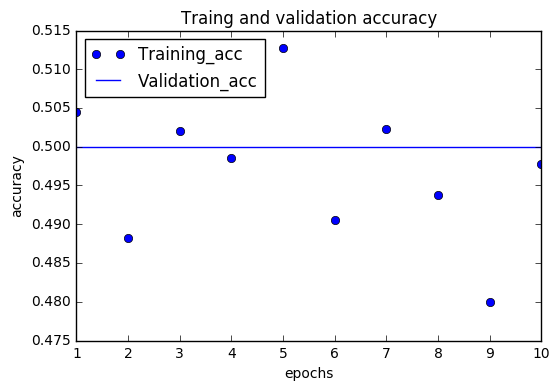

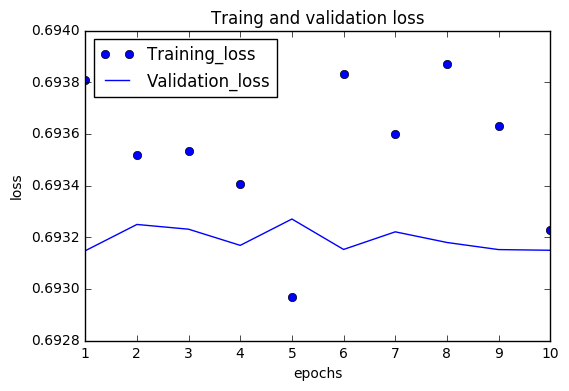

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='Training_acc')
plt.plot(epochs,val_acc,'b',label='Validation_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Traing and validation accuracy')
plt.legend(loc='upper left')

plt.figure()

plt.plot(epochs,loss,'bo',label='Training_loss')
plt.plot(epochs,val_loss,'b',label='Validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Traing and validation loss')
plt.legend(loc='upper left')
plt.show()

训练（train）和验证（evaluate/validate）的逻辑近乎一样，训练要更新权重，但是验证过程，仅仅更新网络状态，不涉及权重（loss以及acc参数）信息的更新

In [14]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
# score = model.evaluate_generator(datagen.flow(x_test, y_test,batch_size=BATCH_SIZE), 
#                                 steps=x_test.shape[0]//BATCH_SIZE) #batches of samples
print(model.metrics_names[0],":",score[0])
print(model.metrics_names[1],":",score[1])

1000/1000 [==============================] - 3s 3ms/step
loss : 0.693149247766
acc : 0.50000000149


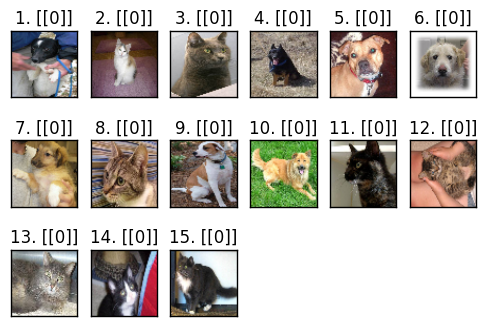

In [15]:
import os
from skimage.transform import resize

test_folder = 'PetImages/images/test'
file_list = os.listdir(test_folder)
cols = 6
rows = len(file_list) // cols + 1
for i,fname in enumerate(file_list):
    img_file = os.path.join(test_folder, fname)
    src_img = plt.imread(img_file)
    dest_img = resize(src_img, (64, 64, 3))
    plt.subplot(rows, cols , i+1)
    plt.imshow(dest_img)
    img = dest_img.reshape((1,)+dest_img.shape)
    result = model.predict_classes(img, batch_size=32, verbose=0) #0=猫，1=狗
    plt.title(str(i+1)+'. '+str(result))
    plt.xticks([])
    plt.yticks([])
plt.show()